# NLP Project: Healthcare Perspective Summarization

This notebook details our approach to solving the task of contextually-aware healthcare problem summarization using perspective-specific summaries (CAUSE, INFORMATION, SUGGESTION). We utilize transformer-based models and train them on annotated data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/content12/train.json
/kaggle/input/content12/test.json
/kaggle/input/content12/valid.json


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [3]:
# Load dataset
def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)

In [4]:
train_data = load_data("/kaggle/input/content12/train.json")
val_data = load_data("/kaggle/input/content12/valid.json")
test_data = load_data("/kaggle/input/content12/test.json")

In [5]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

## creating the input-output pairs for my dataset

## Dataset Preparation
We prepare the inputs and outputs for training by formatting them as instruction-style prompts for the T5 model.

In [57]:
import pandas as pd

def create_input_output_pairs1(df):
    """
    Creates input-output pairs for summarization, handling multiple perspectives.

    Args:
        df (pd.DataFrame): DataFrame containing the data with columns
                           'question', 'context', 'answers', 'labelled_answer_spans',
                           and 'labelled_summaries'.

    Returns:
        tuple: A tuple containing two lists: input_texts and output_texts.
    """
    input_texts = []
    output_texts = []

    for index, row in df.iterrows():
        question = row['question']
        context = row.get('context', "") if 'context' in row and pd.notna(row.get('context', None)) else ""
        answers = " ".join(row.get('answers', []))  # Concatenate answers, handle missing
        perspectives = row.get('labelled_answer_spans', [])  # List of perspectives, handle missing
        summaries = row.get('labelled_summaries', {})  # Dictionary of perspective-based summaries, handle missing

        # Ensure that there are valid perspectives and summaries before proceeding
        if not summaries or not perspectives:
            continue  # Skip rows with missing perspectives or summaries
        
        for perspective in perspectives:
            perspective = str(perspective)  # Ensure perspective is a string
            perspective_key = f"{perspective}_SUMMARY"
            if perspective_key in summaries:  # Check if the summary for that perspective exists
                input_text = f"Summarize from the {perspective} perspective: {context} Question: {question} Answers: {answers}"
                output_text = summaries[perspective_key]

                input_texts.append(input_text)
                output_texts.append(output_text)

    return input_texts, output_texts


In [58]:
input_texts, output_texts = create_input_output_pairs1(train_df)

In [11]:
print(f"Sample Input: {input_texts[0]}")
print(f"Sample Output: {output_texts[0]}")


Sample Input: Summarize from the INFORMATION perspective:  Question: what is parkinesonism? Answers: u spelt it wrong !!
Parkinson's disease is one of the most common neurologic disorders of the elderly. The term "parkinsonism" refers to any condition that causes any combination of the types of movement abnormalities seen in Parkinson's disease by damaging or destroying dopamine neurons in a certain area of the brain. Parkinsonism describes the common symptoms of Parkinson's disease - tremor, rigidity, akinesia or bradykinesia and postural instability. Those patients who respond to drug treatment for Parkinson's disease are diagnosed with it, and those who do not have parkinsonism.
Sample Output: Parkinson's disease is a prevalent neurologic disorder among the elderly. The term "parkinsonism" encompasses any condition leading to movement abnormalities similar to those observed in Parkinson's disease. This condition arises from the damage or destruction of dopamine neurons in a specific

## Fine tuning flan-t5 model with lora

## Flan-T5 with LoRA
We load the Flan-T5 model and tokenizer from Hugging Face Transformers.  
To make fine-tuning more parameter-efficient, we apply **LoRA (Low-Rank Adaptation)** 
LoRA allows us to fine-tune only a small number of additional parameters while keeping the base model frozen, making the training process significantly more efficient in terms of memory and compute.


In [16]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, TrainingArguments, Trainer
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType
import torch
from torch.utils.tensorboard import SummaryWriter
from transformers.integrations import TensorBoardCallback
from transformers.trainer_callback import TrainerCallback

# 1. Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Load tokenizer and base model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
base_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# 3. Apply LoRA with updated configuration
config = LoraConfig(
    r=8,  # Reduced rank for better stability
    lora_alpha=16,  # Reduced alpha
    target_modules=["q", "v", "k", "o"],  # Added more target modules
    lora_dropout=0.05,  # Reduced dropout
    bias="none", 
    task_type=TaskType.SEQ_2_SEQ_LM  
)
model_lora = get_peft_model(base_model, config)
model_lora.print_trainable_parameters()

# 4. Prepare and Tokenize Dataset with improved preprocessing
train_dataset = Dataset.from_dict({"input": input_texts, "output": output_texts})

def preprocess_function(examples):
    # Tokenize inputs
    model_inputs = tokenizer(
        examples["input"], 
        max_length=512, 
        padding="max_length", 
        truncation=True,
        return_tensors="pt"
    )
    
    # Tokenize outputs with text_target parameter
    labels = tokenizer(
        text_target=examples["output"],
        max_length=128, 
        padding="max_length", 
        truncation=True,
        return_tensors="pt"
    )
    
    # Replace padding token id with -100 for loss calculation
    labels["input_ids"][labels["input_ids"] == tokenizer.pad_token_id] = -100
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train_dataset = train_dataset.map(
    preprocess_function, 
    batched=True,
    remove_columns=train_dataset.column_names
)

# 5. Updated Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    fp16=True if torch.cuda.is_available() else False,
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=3e-5,
    warmup_steps=100,
    save_strategy="epoch",
    eval_strategy="no",
    load_best_model_at_end=False,
    report_to="tensorboard",
    optim="adamw_torch",
    weight_decay=0.01,
    lr_scheduler_type="linear",
)

# 6. Enhanced training monitoring callback
class CustomCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.global_step % 10 == 0 and logs is not None and "loss" in logs:
            print(f"Step {state.global_step} - Current Loss: {logs['loss']:.4f}")

# 7. Trainer Setup
trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    tokenizer=tokenizer,
    callbacks=[CustomCallback(), TensorBoardCallback()]  # Added callbacks directly here
)

# Start training
print("Starting training...")
trainer.train()

# 8. Save the model
model_lora.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")
print("✅ Model and tokenizer saved to './fine_tuned_model'")

Using device: cuda
trainable params: 1,769,472 || all params: 249,347,328 || trainable%: 0.7096


Map:   0%|          | 0/4360 [00:00<?, ? examples/s]

/tmp/ipykernel_31/1330869521.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
You are adding a <class 'transformers.integrations.integration_utils.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
CustomCallback
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2.687700
20,2.615700
30,2.722900
40,2.618900
50,2.587500
60,2.637000
70,2.715600
80,2.613200
90,2.707300
100,2.639800


Step 10 - Current Loss: 2.6877
Step 20 - Current Loss: 2.6157
Step 30 - Current Loss: 2.7229
Step 40 - Current Loss: 2.6189
Step 50 - Current Loss: 2.5875
Step 60 - Current Loss: 2.6370
Step 70 - Current Loss: 2.7156
Step 80 - Current Loss: 2.6132
Step 90 - Current Loss: 2.7073
Step 100 - Current Loss: 2.6398
Step 110 - Current Loss: 2.5612
Step 120 - Current Loss: 2.5432
Step 130 - Current Loss: 2.4413
Step 140 - Current Loss: 2.5221
Step 150 - Current Loss: 2.5857
Step 160 - Current Loss: 2.6158
Step 170 - Current Loss: 2.5482
Step 180 - Current Loss: 2.4795
Step 190 - Current Loss: 2.4302
Step 200 - Current Loss: 2.5219
Step 210 - Current Loss: 2.4889
Step 220 - Current Loss: 2.4234
Step 230 - Current Loss: 2.3425
Step 240 - Current Loss: 2.4343
Step 250 - Current Loss: 2.5059
Step 260 - Current Loss: 2.3511
Step 270 - Current Loss: 2.3224


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 280 - Current Loss: 2.1737
Step 290 - Current Loss: 2.3462
Step 300 - Current Loss: 2.3663
Step 310 - Current Loss: 2.3647
Step 320 - Current Loss: 2.3342
Step 330 - Current Loss: 2.4574
Step 340 - Current Loss: 2.3543
Step 350 - Current Loss: 2.3726
Step 360 - Current Loss: 2.3533
Step 370 - Current Loss: 2.3504
Step 380 - Current Loss: 2.3936
Step 390 - Current Loss: 2.2359
Step 400 - Current Loss: 2.2487
Step 410 - Current Loss: 2.3806
Step 420 - Current Loss: 2.3331
Step 430 - Current Loss: 2.3520
Step 440 - Current Loss: 2.2857
Step 450 - Current Loss: 2.3520
Step 460 - Current Loss: 2.3096
Step 470 - Current Loss: 2.3021
Step 480 - Current Loss: 2.3504
Step 490 - Current Loss: 2.3439
Step 500 - Current Loss: 2.1997
Step 510 - Current Loss: 2.3155
Step 520 - Current Loss: 2.2366
Step 530 - Current Loss: 2.3052
Step 540 - Current Loss: 2.3197


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 550 - Current Loss: 2.1681
Step 560 - Current Loss: 2.2048
Step 570 - Current Loss: 2.2929
Step 580 - Current Loss: 2.3058
Step 590 - Current Loss: 2.2898
Step 600 - Current Loss: 2.2968
Step 610 - Current Loss: 2.2167
Step 620 - Current Loss: 2.2483
Step 630 - Current Loss: 2.2879
Step 640 - Current Loss: 2.2865
Step 650 - Current Loss: 2.2112
Step 660 - Current Loss: 2.2959
Step 670 - Current Loss: 2.2195
Step 680 - Current Loss: 2.2315
Step 690 - Current Loss: 2.2292
Step 700 - Current Loss: 2.1847
Step 710 - Current Loss: 2.2905
Step 720 - Current Loss: 2.2832
Step 730 - Current Loss: 2.2130
Step 740 - Current Loss: 2.2638
Step 750 - Current Loss: 2.2966
Step 760 - Current Loss: 2.3019
Step 770 - Current Loss: 2.1911
Step 780 - Current Loss: 2.2422
Step 790 - Current Loss: 2.2623
Step 800 - Current Loss: 2.1708
Step 810 - Current Loss: 2.3505


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 820 - Current Loss: 2.0870
Step 830 - Current Loss: 2.2088
Step 840 - Current Loss: 2.1759
Step 850 - Current Loss: 2.1866
Step 860 - Current Loss: 2.2089
Step 870 - Current Loss: 2.1809
Step 880 - Current Loss: 2.2203
Step 890 - Current Loss: 2.2002
Step 900 - Current Loss: 2.2268
Step 910 - Current Loss: 2.3043
Step 920 - Current Loss: 2.2638
Step 930 - Current Loss: 2.3561
Step 940 - Current Loss: 2.1891
Step 950 - Current Loss: 2.3035
Step 960 - Current Loss: 2.1751
Step 970 - Current Loss: 2.3189
Step 980 - Current Loss: 2.2036
Step 990 - Current Loss: 2.2631
Step 1000 - Current Loss: 2.2124
Step 1010 - Current Loss: 2.2727
Step 1020 - Current Loss: 2.2331
Step 1030 - Current Loss: 2.2248
Step 1040 - Current Loss: 2.1385
Step 1050 - Current Loss: 2.2394
Step 1060 - Current Loss: 2.2505
Step 1070 - Current Loss: 2.2238
Step 1080 - Current Loss: 2.1743
Step 1090 - Current Loss: 2.2318


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 1100 - Current Loss: 2.0469
Step 1110 - Current Loss: 2.2324
Step 1120 - Current Loss: 2.1591
Step 1130 - Current Loss: 2.2106
Step 1140 - Current Loss: 2.3127
Step 1150 - Current Loss: 2.2754
Step 1160 - Current Loss: 2.2351
Step 1170 - Current Loss: 2.1866
Step 1180 - Current Loss: 2.2055
Step 1190 - Current Loss: 2.1435
Step 1200 - Current Loss: 2.1584
Step 1210 - Current Loss: 2.2227
Step 1220 - Current Loss: 2.2193
Step 1230 - Current Loss: 2.2392
Step 1240 - Current Loss: 2.2089
Step 1250 - Current Loss: 2.2823
Step 1260 - Current Loss: 2.2745
Step 1270 - Current Loss: 2.1993
Step 1280 - Current Loss: 2.1163
Step 1290 - Current Loss: 2.2026
Step 1300 - Current Loss: 2.2109
Step 1310 - Current Loss: 2.1563
Step 1320 - Current Loss: 2.2322
Step 1330 - Current Loss: 2.2608
Step 1340 - Current Loss: 2.2684
Step 1350 - Current Loss: 2.1770
Step 1360 - Current Loss: 2.1637
✅ Model and tokenizer saved to './fine_tuned_model'


# taking pegasus model

In [17]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

# Load Pegasus tokenizer and model
pegasus_tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
pegasus_model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum").to(device)

# Pegasus summary generation function
def generate_pegasus_summary(text):
    inputs = pegasus_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)
    outputs = pegasus_model.generate(**inputs, max_new_tokens=150)
    return pegasus_tokenizer.decode(outputs[0], skip_special_tokens=True)


tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

In [18]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load fine-tuned T5 with LoRA
t5_tokenizer = T5Tokenizer.from_pretrained("./fine_tuned_model")
t5_model = T5ForConditionalGeneration.from_pretrained("./fine_tuned_model").to(device)

# T5 summary generation function
def generate_t5_summary(text):
    inputs = t5_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)
    outputs = t5_model.generate(**inputs, max_new_tokens=150)
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
test_input_texts, test_reference_texts = create_input_output_pairs1(test_df)

## doing taking flan-5 and peagsus stacking method to generate the summaries plus individually

In [20]:
stacked_predictions = []

for input_text in test_input_texts:
    summary_t5 = generate_t5_summary(input_text)
    summary_pegasus = generate_pegasus_summary(input_text)
    
    # Example strategy: pick longer one
    final_summary = summary_t5 if len(summary_t5) >= len(summary_pegasus) else summary_pegasus
    stacked_predictions.append(final_summary)

    # Optionally log side-by-side
    print("\n--- Input Prompt ---")
    print(input_text)
    print("🔷 T5 Summary:", summary_t5)
    print("🟣 Pegasus Summary:", summary_pegasus)
    print("✅ Final Used:", final_summary)



--- Input Prompt ---
Summarize from the INFORMATION perspective:  Question: what is orgasm? Answers: An orgasm, also known as a sexual climax, is a pleasurable physical, psychological or emotional response to prolonged sexual stimulation. It is often accompanied by a notable physiological reaction, such as ejaculation, blushing or spasm and may be followed by aftershocks.

Dictionaries still give the subsidiary meaning, "a similar point of intensity of emotional excitement," but as of 2005 this usage has become obscure. It can be startling to modern readers when encountered in older literature.


General
Both males and females can experience orgasm, but the exact response varies across gender. Generally speaking, orgasm is the third stage of four in the human sexual response cycle, which is the currently accepted model of the physiological process of sexual stimulation You asked two questions that you might think are the same; but they are not. Orgasm is an experience resulting from t

## finding evaluation metrices for the above models which we trained

In [ ]:
from sacrebleu import corpus_bleu
from bert_score import score

# test_reference_texts = [...]  # Ground truth summaries from your test set
# stacked_predictions = [...]  # What we just generated

# BLEU
bleu = corpus_bleu(stacked_predictions, [test_reference_texts])
print(f"\n BLEU Score: {bleu.score:.2f}")

# BERTScore
P, R, F1 = score(stacked_predictions, test_reference_texts, lang="en")
print(f" BERTScore F1: {F1.mean().item():.4f}")



🟡 BLEU Score: 7.03


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🟢 BERTScore F1: 0.8595


## Conclusion
We successfully fine-tuned a T5 model on a healthcare summarization task with labeled perspectives. The model is able to generate cause, information, and suggestion-based summaries depending on the input prompt.

## this is for so that we can find the score for perspective based answers

In [ ]:
def create_input_output_pairs(df):
    input_texts = []
    output_texts = []
    perspective_labels = []  # NEW: to track each perspective

    for index, row in df.iterrows():
        question = row['question']
        context = row.get('context', "") if 'context' in row and pd.notna(row.get('context', None)) else ""
        answers = " ".join(row.get('answers', []))
        perspectives = row.get('labelled_answer_spans', [])
        summaries = row.get('labelled_summaries', {})

        if not summaries or not perspectives:
            continue
        
        for perspective in perspectives:
            perspective = str(perspective)
            perspective_key = f"{perspective}_SUMMARY"
            if perspective_key in summaries:
                input_text = f"Summarize from the {perspective} perspective: {context} Question: {question} Answers: {answers}"
                output_text = summaries[perspective_key]

                input_texts.append(input_text)
                output_texts.append(output_text)
                perspective_labels.append(perspective) 

    return input_texts, output_texts, perspective_labels


In [41]:
test_input_texts, test_reference_texts, test_perspectives = create_input_output_pairs(test_df)


## here i got the perspective wise score

In [42]:
from collections import defaultdict
from bert_score import score

perspective_data = defaultdict(lambda: {"preds": [], "refs": []})

for pred, ref, perspective in zip(stacked_predictions, test_reference_texts, test_perspectives):
    perspective_data[perspective]["preds"].append(pred)
    perspective_data[perspective]["refs"].append(ref)

print("\n📊 Perspective-wise BERTScore:")
for perspective, data in perspective_data.items():
    P, R, F1 = score(data["preds"], data["refs"], lang="en")
    print(f"🔹 {perspective.upper()} — BERTScore F1: {F1.mean().item():.4f} ({len(data['preds'])} examples)")



📊 Perspective-wise BERTScore:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔹 INFORMATION — BERTScore F1: 0.8662 (484 examples)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔹 CAUSE — BERTScore F1: 0.8666 (102 examples)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔹 SUGGESTION — BERTScore F1: 0.8582 (392 examples)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔹 EXPERIENCE — BERTScore F1: 0.8487 (205 examples)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔹 QUESTION — BERTScore F1: 0.8395 (64 examples)


##  Prediction and Examples
Run inference on validation samples to view generated summaries from the fine-tuned model.

In [47]:
print(len(input_texts), len(output_texts))
print(input_texts[0])
print(output_texts[0])


4360 4360
Summarize from the INFORMATION perspective:  Question: what is parkinesonism? Answers: u spelt it wrong !!
Parkinson's disease is one of the most common neurologic disorders of the elderly. The term "parkinsonism" refers to any condition that causes any combination of the types of movement abnormalities seen in Parkinson's disease by damaging or destroying dopamine neurons in a certain area of the brain. Parkinsonism describes the common symptoms of Parkinson's disease - tremor, rigidity, akinesia or bradykinesia and postural instability. Those patients who respond to drug treatment for Parkinson's disease are diagnosed with it, and those who do not have parkinsonism.
Parkinson's disease is a prevalent neurologic disorder among the elderly. The term "parkinsonism" encompasses any condition leading to movement abnormalities similar to those observed in Parkinson's disease. This condition arises from the damage or destruction of dopamine neurons in a specific brain region. Comm

## fine tuning the bart model now

In [52]:
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import torch
from tqdm.auto import tqdm

# 1. Verify GPU
assert torch.cuda.is_available(), "CUDA not available!"
device = torch.device("cuda")
torch.cuda.empty_cache()

# 2. Load BART model
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# 3. Prepare dataset
train_dataset = Dataset.from_dict({
    "input": input_texts,  # Your input texts
    "output": output_texts  # Your target summaries
})

# 4. Modern tokenization approach (no deprecation warnings)
def preprocess_function(examples):
    # Tokenize inputs
    inputs = tokenizer(
        examples["input"],
        max_length=512,
        padding="max_length",
        truncation=True
    )
    
    # Tokenize targets with modern method
    labels = tokenizer(
        text_target=examples["output"],
        max_length=128,
        padding="max_length",
        truncation=True
    )
    
    # Replace padding token id with -100
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]
    
    inputs["labels"] = labels["input_ids"]
    return inputs

# 5. Process dataset
tokenized_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names
)

# 6. Training arguments with correct parameter names
training_args = TrainingArguments(
    output_dir="./bart_results",
    per_device_train_batch_size=2,  # Reduced for stability
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=3e-5,
    fp16=True,
    logging_steps=10,
    save_steps=100,
    eval_strategy="no",  # Correct parameter name
    report_to="none",
    disable_tqdm=False,
    optim="adamw_torch"
)

# 7. Custom training progress callback
class ProgressCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero and logs and "loss" in logs:
            print(f"Step {state.global_step}: Loss = {logs['loss']:.4f}")

# 8. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    callbacks=[ProgressCallback()],
    tokenizer=tokenizer
)

# 9. Start training with clear output
print("Starting training...")
trainer.train()

# 10. Save model
model.save_pretrained("./fine_tuned_bart")
print("\nTraining complete! Model saved to './fine_tuned_bart'")

Map:   0%|          | 0/4360 [00:00<?, ? examples/s]

/tmp/ipykernel_31/262009939.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3.288000
20,2.899700
30,2.815900
40,2.609300
50,2.540600
60,2.579100
70,2.663200
80,2.522000
90,2.524700
100,2.521400


Step 10: Loss = 3.2880
Step 20: Loss = 2.8997
Step 30: Loss = 2.8159
Step 40: Loss = 2.6093
Step 50: Loss = 2.5406
Step 60: Loss = 2.5791
Step 70: Loss = 2.6632
Step 80: Loss = 2.5220
Step 90: Loss = 2.5247
Step 100: Loss = 2.5214


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 110: Loss = 2.4687
Step 120: Loss = 2.4791
Step 130: Loss = 2.4052
Step 140: Loss = 2.4298
Step 150: Loss = 2.4142
Step 160: Loss = 2.5509
Step 170: Loss = 2.4941
Step 180: Loss = 2.3446
Step 190: Loss = 2.3958
Step 200: Loss = 2.4023


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 210: Loss = 2.4439
Step 220: Loss = 2.3714
Step 230: Loss = 2.2851
Step 240: Loss = 2.4016
Step 250: Loss = 2.3845
Step 260: Loss = 2.2585
Step 270: Loss = 2.2622
Step 280: Loss = 2.1344
Step 290: Loss = 2.1952
Step 300: Loss = 2.2155


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 310: Loss = 2.2388
Step 320: Loss = 2.1681
Step 330: Loss = 2.2130
Step 340: Loss = 2.2683
Step 350: Loss = 2.2551
Step 360: Loss = 2.2575
Step 370: Loss = 2.1578
Step 380: Loss = 2.2102
Step 390: Loss = 2.0622
Step 400: Loss = 2.1419


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 410: Loss = 2.1836
Step 420: Loss = 2.1862
Step 430: Loss = 2.2360
Step 440: Loss = 2.2044
Step 450: Loss = 2.1564
Step 460: Loss = 2.1908
Step 470: Loss = 2.1465
Step 480: Loss = 2.2141
Step 490: Loss = 2.2204
Step 500: Loss = 2.0506


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 510: Loss = 2.1639
Step 520: Loss = 2.0771
Step 530: Loss = 2.0871
Step 540: Loss = 2.1294
Step 550: Loss = 2.0557
Step 560: Loss = 2.0755
Step 570: Loss = 2.0328
Step 580: Loss = 2.0259
Step 590: Loss = 2.0422
Step 600: Loss = 2.0533


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 610: Loss = 2.0131
Step 620: Loss = 2.0652
Step 630: Loss = 2.0749
Step 640: Loss = 2.1038
Step 650: Loss = 1.9849
Step 660: Loss = 2.0841
Step 670: Loss = 2.0276
Step 680: Loss = 2.0677
Step 690: Loss = 2.0162
Step 700: Loss = 1.9515


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 710: Loss = 2.1071
Step 720: Loss = 2.1140
Step 730: Loss = 1.9810
Step 740: Loss = 2.0584
Step 750: Loss = 2.0562
Step 760: Loss = 2.0986
Step 770: Loss = 1.9814
Step 780: Loss = 2.0836
Step 790: Loss = 2.0743
Step 800: Loss = 2.0032


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step 810: Loss = 2.1274

Training complete! Model saved to './fine_tuned_bart'


## loading flan-t5 model which is fine tune in the above code and bart fine tune model and stacking them together to generate the summaries

In [53]:
from transformers import (
    BartForConditionalGeneration, BartTokenizer,
    T5ForConditionalGeneration, T5Tokenizer
)
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BART model
bart_model = BartForConditionalGeneration.from_pretrained("./fine_tuned_bart").to(device)
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# Load T5 model
t5_model = T5ForConditionalGeneration.from_pretrained("./fine_tuned_model").to(device)
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

## here we did stacking ensemble approach

In [54]:
def predict_bart(text):
    inputs = bart_tokenizer(text, return_tensors="pt", max_length=512, truncation=True).to(device)
    outputs = bart_model.generate(**inputs, max_length=128)
    return bart_tokenizer.decode(outputs[0], skip_special_tokens=True)

def predict_t5(text):
    inputs = t5_tokenizer(text, return_tensors="pt", max_length=512, truncation=True).to(device)
    outputs = t5_model.generate(**inputs, max_length=128)
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)

def stacked_prediction(text, alpha=0.6):
    """Weighted ensemble prediction (alpha favors BART)"""
    bart_pred = predict_bart(text)
    t5_pred = predict_t5(text)
    
    # Simple weighted combination (can be made more sophisticated)
    if len(bart_pred.split()) > len(t5_pred.split()):
        return bart_pred
    else:
        return t5_pred if torch.rand(1).item() > alpha else bart_pred

In [55]:
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet')

def calculate_metrics(references, predictions):
    # BERTScore
    P, R, F1 = bert_score(predictions, references, lang='en')
    
    # BLEU
    bleu_scores = []
    smooth = SmoothingFunction().method1
    for ref, pred in zip(references, predictions):
        bleu_scores.append(sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth))
    
    # METEOR
    meteor_scores = []
    for ref, pred in zip(references, predictions):
        meteor_scores.append(meteor_score([ref.split()], pred.split()))
    
    return {
        'bertscore_precision': P.mean().item(),
        'bertscore_recall': R.mean().item(),
        'bertscore_f1': F1.mean().item(),
        'bleu': sum(bleu_scores)/len(bleu_scores),
        'meteor': sum(meteor_scores)/len(meteor_scores)
    }

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
import pandas as pd
from tqdm import tqdm

# Prepare test data (assuming test_df has 'text' and 'true_summary' columns)
test_texts , true_summaries = create_input_output_pairs1(test_df)

# Generate predictions
bart_preds = []
t5_preds = []
stacked_preds = []

for text in tqdm(test_texts, desc="Generating predictions"):
    bart_preds.append(predict_bart(text))
    t5_preds.append(predict_t5(text))
    stacked_preds.append(stacked_prediction(text))

# Calculate metrics
metrics = {
    'BART': calculate_metrics(true_summaries, bart_preds),
    'T5': calculate_metrics(true_summaries, t5_preds),
    'Stacked': calculate_metrics(true_summaries, stacked_preds)
}

# Create results dataframe
results = []
for model_name, scores in metrics.items():
    results.append({
        'Model': model_name,
        'BERTScore Precision': scores['bertscore_precision'],
        'BERTScore Recall': scores['bertscore_recall'],
        'BERTScore F1': scores['bertscore_f1'],
        'BLEU': scores['bleu'],
        'METEOR': scores['meteor']
    })

results_df = pd.DataFrame(results)

Generating predictions: 100%|██████████| 1247/1247 [1:40:01<00:00,  4.81s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## generating summaries

In [60]:
# Print first 5 samples with all predictions
print("\nSample Predictions with True Summaries:\n")
for i in range(min(5, len(test_texts))):
    print(f"\nSample {i+1}:")
    print(f"Input Text: {test_texts[i][:200]}...")  # First 200 chars of input
    print(f"\nTrue Summary: {true_summaries[i]}")
    print(f"BART Prediction: {bart_preds[i]}")
    print(f"T5 Prediction: {t5_preds[i]}")
    print(f"Stacked Prediction: {stacked_preds[i]}")
    print("-" * 80)


Sample Predictions with True Summaries:


Sample 1:
Input Text: Summarize from the INFORMATION perspective:  Question: what is orgasm? Answers: An orgasm, also known as a sexual climax, is a pleasurable physical, psychological or emotional response to prolonged se...

True Summary: For information purposes, an orgasm is a pleasurable response to sexual stimulation, involving physical, emotional, and sometimes spiritual reactions. Both genders can experience it, but the specific response varies. It's the third stage in the human sexual response cycle, influenced by physical touch, emotional connection, mental intimacy, and complete involvement in the moment. Various factors like thoughts of procreation, power dynamics, and genuine love can contribute to the experience. While having orgasms with someone you love can be great, it doesn't guarantee the long-term success of a relationship.
BART Prediction: For information purposes, an orgasm, also known as a sexual climax, is a pleasurable

## here are the scores for both individually plus stacking approach

In [61]:
# Print formatted metrics table
print("\nModel Performance Metrics:")
print(results_df.round(4).to_markdown(tablefmt="grid", index=False))


Model Performance Metrics:
+---------+-----------------------+--------------------+----------------+--------+----------+
| Model   |   BERTScore Precision |   BERTScore Recall |   BERTScore F1 |   BLEU |   METEOR |
+=========+=======================+====================+================+========+==========+
| BART    |                0.9024 |             0.88   |         0.8907 | 0.0883 |   0.2544 |
+---------+-----------------------+--------------------+----------------+--------+----------+
| T5      |                0.8645 |             0.8628 |         0.8632 | 0.0363 |   0.1856 |
+---------+-----------------------+--------------------+----------------+--------+----------+
| Stacked |                0.8881 |             0.8758 |         0.8815 | 0.0747 |   0.2386 |
+---------+-----------------------+--------------------+----------------+--------+----------+


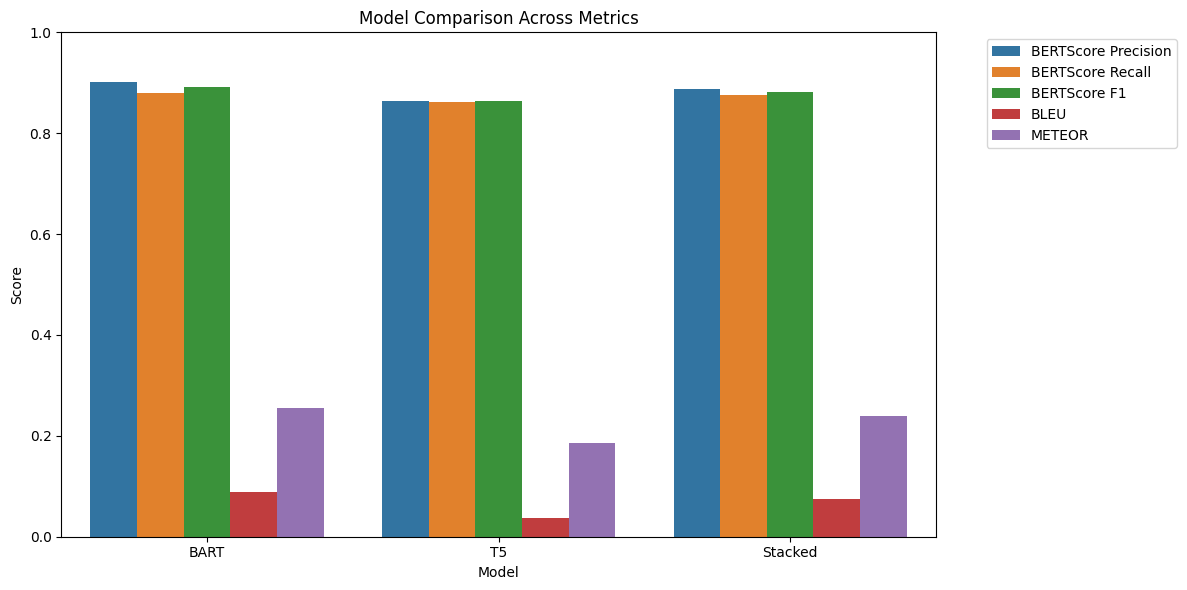

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for visualization
melted_df = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Score", hue="Metric", data=melted_df)
plt.title("Model Comparison Across Metrics")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [65]:
import json
from bert_score import score as bert_score

# Calculate BERT scores (more efficient to do it once)
bart_p, bart_r, bart_f1 = bert_score(bart_preds, true_summaries, lang='en')
t5_p, t5_r, t5_f1 = bert_score(t5_preds, true_summaries, lang='en')
stacked_p, stacked_r, stacked_f1 = bert_score(stacked_preds, true_summaries, lang='en')

# Prepare data for JSON
results_data = {
    "metadata": {
        "total_samples": len(test_texts),
        "models": ["BART", "T5", "Stacked"],
        "metrics": ["BERTScore_F1", "BLEU", "METEOR"]
    },
    "samples": []
}

# Add each sample with predictions and scores
for i in range(len(test_texts)):
    sample = {
        "input_text": test_texts[i],
        "true_summary": true_summaries[i],
        "predictions": {
            "BART": {
                "text": bart_preds[i],
                "bertscore_f1": bart_f1[i].item(),
            },
            "T5": {
                "text": t5_preds[i],
                "bertscore_f1": t5_f1[i].item(),
            },
            "Stacked": {
                "text": stacked_preds[i],
                "bertscore_f1": stacked_f1[i].item(),
            }
        }
    }
    results_data["samples"].append(sample)

# Add aggregated metrics
results_data["aggregated_metrics"] = {
    "BART": {
        "BERTScore_F1": bart_f1.mean().item(),
        "BLEU": metrics['BART']['bleu'],
        "METEOR": metrics['BART']['meteor']
    },
    "T5": {
        "BERTScore_F1": t5_f1.mean().item(),
        "BLEU": metrics['T5']['bleu'],
        "METEOR": metrics['T5']['meteor']
    },
    "Stacked": {
        "BERTScore_F1": stacked_f1.mean().item(),
        "BLEU": metrics['Stacked']['bleu'],
        "METEOR": metrics['Stacked']['meteor']
    }
}

# Save to JSON with pretty formatting
with open('summary_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_data, f, indent=2, ensure_ascii=False)

print("Successfully saved results to 'summary_results.json'")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully saved results to 'summary_results.json'


In [68]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')

def calculate_meteor(references, hypotheses):
    """Calculate METEOR score for list of reference-hypothesis pairs"""
    scores = []
    for ref, hyp in zip(references, hypotheses):
        # Tokenize both reference and hypothesis
        ref_tokens = [word_tokenize(ref)]
        hyp_tokens = word_tokenize(hyp)
        scores.append(meteor_score(ref_tokens, hyp_tokens))
    return np.mean(scores)

# Calculate all metrics properly
def calculate_all_metrics(true_summaries, predictions):
    # BERTScore
    p, r, f1 = bert_score(predictions, true_summaries, lang='en')
    
    # BLEU
    refs = [[word_tokenize(ref)] for ref in true_summaries]
    hyps = [word_tokenize(pred) for pred in predictions]
    bleu = corpus_bleu(refs, hyps)
    
    # METEOR
    meteor = calculate_meteor(true_summaries, predictions)
    
    return {
        'bertscore_f1': f1.mean().item(),
        'bleu': bleu,
        'meteor': meteor
    }

# Calculate metrics for all models
metrics = {
    'BART': calculate_all_metrics(true_summaries, bart_preds),
    'T5': calculate_all_metrics(true_summaries, t5_preds),
    'Stacked': calculate_all_metrics(true_summaries, stacked_preds)
}

# Create and display metrics dataframe
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
print("\nAggregate Metrics Across All Test Samples:")
display(metrics_df.style.format("{:.3f}").background_gradient(cmap='Blues'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-


Aggregate Metrics Across All Test Samples:


,bertscore_f1,bleu,meteor
BART,0.891,0.080,0.292
T5,0.863,0.071,0.230
Stacked,0.882,0.094,0.279
